# Import

In [1]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ExponentialLR
import sys, os

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname("src"))))

from src.Mydataloader import LoadDataset
from src.Mymodel import MyResNet_CIFAR
from src.Mytraining import DoTraining
from src.Earlystopper import EarlyStopper
from src.LogViewer import LogViewer

# Setup

In [2]:
"""Dataset selection"""
DATASET = "CIFAR10"
# DATASET = "CIFAR100"
# DATASET = "ImageNet2012"

"""Dataset parameters"""
BATCH = 128
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True

"""optimizer parameters"""
# OPTIMIZER = "Adam"
OPTIMIZER = "Adam_decay"
# OPTIMIZER = "SGD"
# OPTIMIZER = "SGD_nasterov"
# OPTIMIZER = "AdamW"
# OPTIMIZER = "AdamW_amsgrad"
# OPTIMIZER = "NAdam"

"""Learning rate scheduler parameters"""
NUM_EPOCHS = 100

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = 100

file_name = f"MyResNet32_{BATCH}_{OPTIMIZER}"

In [3]:
file_name

'MyResNet32_128_Adam_decay'

# Loading the dataset

## Define Dateloader

In [4]:
tmp = LoadDataset(root="../../../data", seceted_dataset=DATASET)
train_data, valid_data, test_data, COUNT_OF_CLASSES = tmp.Unpack()

/home/lee/anaconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


-----------------------------------------------------------------------
Dataset :  CIFAR10
- Length of Train Set :  50000
- Length of Test Set :  10000
- Count of Classes :  10
-----------------------------------------------------------------------


In [5]:
train_dataloader, valid_dataloader, test_dataloader = tmp.get_dataloader(
    batch_size=BATCH, shuffle=SHUFFLE, num_workers=NUMOFWORKERS, pin_memory=PIN_MEMORY
)

train.transforms = Compose(
      AutoAugment(interpolation=InterpolationMode.NEAREST, policy=AutoAugmentPolicy.CIFAR10)
      RandomCrop(size=(32, 32), padding=[4, 4, 4, 4], pad_if_needed=False, fill=0, padding_mode=constant)
      RandomHorizontalFlip(p=0.5)
      ToTensor()
      Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[1, 1, 1], inplace=True)
) 128
test.transforms = ToTensor() 128


# Define ResNet

## Model Confirm

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
model = MyResNet_CIFAR(num_classes=COUNT_OF_CLASSES, num_layer_factor=5).to(device)

# Define Training

## (1) Define Criterion

In [8]:
criterion = nn.CrossEntropyLoss()

## (2) Define Optimazer

In [9]:
if OPTIMIZER == "Adam":
    optimizer = torch.optim.Adam(model.parameters())
elif OPTIMIZER == "Adam_decay":
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4
    )
elif OPTIMIZER == "SGD_nasterov":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4, nesterov=True
    )
elif OPTIMIZER == "AdamW":
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "AdamW_amsgrad":
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4, amsgrad=True)
elif OPTIMIZER == "NAdam":
    optimizer = torch.optim.NAdam(model.parameters(), weight_decay=1e-4)

## (3) Define Early Stopping

In [10]:
earlystopper = EarlyStopper(patience=EARLYSTOPPINGPATIENCE, model=model, file_name=file_name)

## (4) Define Learning Rate schedualer

In [11]:
scheduler = ExponentialLR(optimizer, gamma=0.95)

## (5) Define AMP scaler

In [12]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

## Load before process

In [13]:
if os.path.exists(file_name + ".pth.tar"):
    # Read checkpoint as desired, e.g.,
    checkpoint = torch.load(
        file_name + ".pth.tar",
        map_location=lambda storage, loc: storage.cuda(device),
    )
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scaler.load_state_dict(checkpoint["scaler"])
    scheduler.load_state_dict(checkpoint["scheduler"])
    earlystopper.load_state_dict(checkpoint["earlystopper"])
    logs = checkpoint["logs"]

    print("Suceessfully loaded the All setting and Log file.")
    print(file_name)
    print(f"Current epoch is {len(logs['train_loss'])}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
else:
    # Create a dictionary to store the variables
    train_loss = []
    train_acc = []
    eval_loss = []
    valid_acc = []
    test_loss = []
    test_acc = []
    lr_log = []
    logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "valid_loss": eval_loss,
        "valid_acc": valid_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "lr_log": lr_log,
    }
    print("File does not exist. Created a new log.")

File does not exist. Created a new log.


In [14]:
optimizer.param_groups[0]["lr"]

0.001

In [15]:
earlystopper.early_stop_counter

0

# [Training Loop]

In [16]:
Training = DoTraining(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    scheduler=scheduler,
    earlystopper=earlystopper,
    device=device,
    logs=logs,
    file_path=file_name,
)
pre_epochs = len(Training.logs["train_loss"])

for epoch in range(NUM_EPOCHS):
    now = epoch + 1 + pre_epochs
    print(f"[Epoch {epoch+1+pre_epochs}/{NUM_EPOCHS}] :")

    if DATASET == "ImageNet2012":
        eval_loss = Training.SingleEpoch(train_dataloader, valid_dataloader)
    else:
        eval_loss = Training.SingleEpoch(
            train_dataloader, valid_dataloader, test_dataloader
        )

    Training.Save()

    
    
    if earlystopper.check(eval_loss) == True:
        break

    print("-" * 50)

[Epoch 1/100] :


1 Train: 100%|███████| 391/391 [00:08<00:00, 45.56it/s]

Train Loss: 1.6936 | Train Acc: 38.78%


Test  Loss: 1.4143 | Test Acc: 50.55%
updated best eval loss : 1.4142784589453588
--------------------------------------------------
[Epoch 2/100] :


2 Train: 100%|███████| 391/391 [00:18<00:00, 21.16it/s]


Train Loss: 1.2651 | Train Acc: 54.86%
Test  Loss: 1.7357 | Test Acc: 47.21%
--------------------------------------------------
[Epoch 3/100] :


3 Train: 100%|███████| 391/391 [00:29<00:00, 13.24it/s]


Train Loss: 1.0715 | Train Acc: 62.09%
Test  Loss: 0.9703 | Test Acc: 65.47%
updated best eval loss : 0.9702960237672057
--------------------------------------------------
[Epoch 4/100] :


4 Train: 100%|███████| 391/391 [00:30<00:00, 12.77it/s]


Train Loss: 0.9703 | Train Acc: 65.76%
Test  Loss: 1.0866 | Test Acc: 64.41%
--------------------------------------------------
[Epoch 5/100] :


5 Train: 100%|███████| 391/391 [00:28<00:00, 13.49it/s]


Train Loss: 0.8939 | Train Acc: 68.67%
Test  Loss: 1.0898 | Test Acc: 63.89%
--------------------------------------------------
[Epoch 6/100] :


6 Train: 100%|███████| 391/391 [00:30<00:00, 12.65it/s]


Train Loss: 0.8330 | Train Acc: 70.75%
Test  Loss: 0.7587 | Test Acc: 73.99%
updated best eval loss : 0.7586666285237179
--------------------------------------------------
[Epoch 7/100] :


7 Train: 100%|███████| 391/391 [00:32<00:00, 11.90it/s]


Train Loss: 0.7885 | Train Acc: 72.42%
Test  Loss: 0.7902 | Test Acc: 73.07%
--------------------------------------------------
[Epoch 8/100] :


8 Train: 100%|███████| 391/391 [00:30<00:00, 12.78it/s]


Train Loss: 0.7548 | Train Acc: 73.74%
Test  Loss: 0.8434 | Test Acc: 72.43%
--------------------------------------------------
[Epoch 9/100] :


9 Train: 100%|███████| 391/391 [00:30<00:00, 12.94it/s]


Train Loss: 0.7237 | Train Acc: 74.71%
Test  Loss: 0.9506 | Test Acc: 70.07%
--------------------------------------------------
[Epoch 10/100] :


10 Train: 100%|██████| 391/391 [00:31<00:00, 12.44it/s]


Train Loss: 0.6966 | Train Acc: 75.69%
Test  Loss: 0.7416 | Test Acc: 76.05%
updated best eval loss : 0.7416256900075116
--------------------------------------------------
[Epoch 11/100] :


11 Train: 100%|██████| 391/391 [00:37<00:00, 10.39it/s]


Train Loss: 0.6757 | Train Acc: 76.46%
Test  Loss: 0.6064 | Test Acc: 79.45%
updated best eval loss : 0.606440550541576
--------------------------------------------------
[Epoch 12/100] :


12 Train: 100%|██████| 391/391 [00:48<00:00,  8.12it/s]


Train Loss: 0.6572 | Train Acc: 77.13%
Test  Loss: 0.6701 | Test Acc: 77.25%
--------------------------------------------------
[Epoch 13/100] :


13 Train: 100%|██████| 391/391 [00:47<00:00,  8.20it/s]


Train Loss: 0.6383 | Train Acc: 77.78%
Test  Loss: 0.6897 | Test Acc: 76.60%
--------------------------------------------------
[Epoch 14/100] :


14 Train: 100%|██████| 391/391 [00:36<00:00, 10.81it/s]


Train Loss: 0.6280 | Train Acc: 78.16%
Test  Loss: 0.5654 | Test Acc: 80.45%
updated best eval loss : 0.565371579384502
--------------------------------------------------
[Epoch 15/100] :


15 Train: 100%|██████| 391/391 [00:35<00:00, 10.94it/s]


Train Loss: 0.6078 | Train Acc: 78.97%
Test  Loss: 0.6187 | Test Acc: 79.80%
--------------------------------------------------
[Epoch 16/100] :


16 Train: 100%|██████| 391/391 [00:33<00:00, 11.84it/s]


Train Loss: 0.5996 | Train Acc: 79.01%
Test  Loss: 0.5360 | Test Acc: 81.25%
updated best eval loss : 0.5359701744363278
--------------------------------------------------
[Epoch 17/100] :


17 Train: 100%|██████| 391/391 [00:35<00:00, 11.00it/s]


Train Loss: 0.5792 | Train Acc: 79.92%
Test  Loss: 0.5530 | Test Acc: 81.62%
--------------------------------------------------
[Epoch 18/100] :


18 Train: 100%|██████| 391/391 [00:35<00:00, 11.03it/s]


Train Loss: 0.5659 | Train Acc: 80.25%
Test  Loss: 0.6063 | Test Acc: 79.32%
--------------------------------------------------
[Epoch 19/100] :


19 Train: 100%|██████| 391/391 [00:35<00:00, 11.00it/s]


Train Loss: 0.5556 | Train Acc: 80.83%
Test  Loss: 0.5796 | Test Acc: 80.10%
--------------------------------------------------
[Epoch 20/100] :


20 Train: 100%|██████| 391/391 [00:34<00:00, 11.41it/s]


Train Loss: 0.5505 | Train Acc: 80.69%
Test  Loss: 0.7434 | Test Acc: 75.88%
--------------------------------------------------
[Epoch 21/100] :


21 Train: 100%|██████| 391/391 [00:34<00:00, 11.26it/s]


Train Loss: 0.5344 | Train Acc: 81.36%
Test  Loss: 0.6227 | Test Acc: 79.00%
--------------------------------------------------
[Epoch 22/100] :


22 Train: 100%|██████| 391/391 [00:34<00:00, 11.21it/s]


Train Loss: 0.5300 | Train Acc: 81.56%
Test  Loss: 0.6055 | Test Acc: 80.17%
--------------------------------------------------
[Epoch 23/100] :


23 Train: 100%|██████| 391/391 [00:35<00:00, 10.95it/s]


Train Loss: 0.5185 | Train Acc: 81.88%
Test  Loss: 0.5491 | Test Acc: 81.26%
--------------------------------------------------
[Epoch 24/100] :


24 Train: 100%|██████| 391/391 [00:48<00:00,  8.14it/s]


Train Loss: 0.5196 | Train Acc: 81.90%
Test  Loss: 0.5238 | Test Acc: 82.19%
updated best eval loss : 0.5237501731401757
--------------------------------------------------
[Epoch 25/100] :


25 Train: 100%|██████| 391/391 [00:48<00:00,  8.09it/s]


Train Loss: 0.5027 | Train Acc: 82.57%
Test  Loss: 0.5210 | Test Acc: 82.28%
updated best eval loss : 0.5210384066346325
--------------------------------------------------
[Epoch 26/100] :


26 Train: 100%|██████| 391/391 [00:52<00:00,  7.48it/s]


Train Loss: 0.4957 | Train Acc: 82.56%
Test  Loss: 0.4964 | Test Acc: 83.28%
updated best eval loss : 0.4963787680939783
--------------------------------------------------
[Epoch 27/100] :


27 Train: 100%|██████| 391/391 [00:49<00:00,  7.88it/s]


Train Loss: 0.4944 | Train Acc: 82.92%
Test  Loss: 0.6660 | Test Acc: 78.25%
--------------------------------------------------
[Epoch 28/100] :


28 Train: 100%|██████| 391/391 [00:51<00:00,  7.64it/s]


Train Loss: 0.4873 | Train Acc: 82.94%
Test  Loss: 0.4579 | Test Acc: 84.32%
updated best eval loss : 0.457942668772951
--------------------------------------------------
[Epoch 29/100] :


29 Train: 100%|██████| 391/391 [00:48<00:00,  8.07it/s]


Train Loss: 0.4798 | Train Acc: 83.25%
Test  Loss: 0.4795 | Test Acc: 83.77%
--------------------------------------------------
[Epoch 30/100] :


30 Train: 100%|██████| 391/391 [00:51<00:00,  7.63it/s]


Train Loss: 0.4757 | Train Acc: 83.44%
Test  Loss: 0.5985 | Test Acc: 80.50%
--------------------------------------------------
[Epoch 31/100] :


31 Train: 100%|██████| 391/391 [00:50<00:00,  7.79it/s]


Train Loss: 0.4733 | Train Acc: 83.57%
Test  Loss: 0.5449 | Test Acc: 81.18%
--------------------------------------------------
[Epoch 32/100] :


32 Train: 100%|██████| 391/391 [00:50<00:00,  7.81it/s]


Train Loss: 0.4731 | Train Acc: 83.48%
Test  Loss: 0.4766 | Test Acc: 83.37%
--------------------------------------------------
[Epoch 33/100] :


33 Train: 100%|██████| 391/391 [00:48<00:00,  7.99it/s]


Train Loss: 0.4571 | Train Acc: 84.15%
Test  Loss: 0.5425 | Test Acc: 82.01%
--------------------------------------------------
[Epoch 34/100] :


34 Train: 100%|██████| 391/391 [00:49<00:00,  7.89it/s]


Train Loss: 0.4516 | Train Acc: 84.37%
Test  Loss: 0.4788 | Test Acc: 83.47%
--------------------------------------------------
[Epoch 35/100] :


35 Train: 100%|██████| 391/391 [00:48<00:00,  8.02it/s]


Train Loss: 0.4533 | Train Acc: 84.13%
Test  Loss: 0.4744 | Test Acc: 83.98%
--------------------------------------------------
[Epoch 36/100] :


36 Train: 100%|██████| 391/391 [00:50<00:00,  7.79it/s]


Train Loss: 0.4519 | Train Acc: 84.23%
Test  Loss: 0.4310 | Test Acc: 85.41%
updated best eval loss : 0.43103355810612065
--------------------------------------------------
[Epoch 37/100] :


37 Train: 100%|██████| 391/391 [00:51<00:00,  7.62it/s]


Train Loss: 0.4442 | Train Acc: 84.67%
Test  Loss: 0.4817 | Test Acc: 83.56%
--------------------------------------------------
[Epoch 38/100] :


38 Train: 100%|██████| 391/391 [00:49<00:00,  7.95it/s]


Train Loss: 0.4404 | Train Acc: 84.56%
Test  Loss: 0.5332 | Test Acc: 81.93%
--------------------------------------------------
[Epoch 39/100] :


39 Train: 100%|██████| 391/391 [00:51<00:00,  7.62it/s]


Train Loss: 0.4401 | Train Acc: 84.69%
Test  Loss: 0.5179 | Test Acc: 83.13%
--------------------------------------------------
[Epoch 40/100] :


40 Train: 100%|██████| 391/391 [00:49<00:00,  7.90it/s]


Train Loss: 0.4326 | Train Acc: 84.90%
Test  Loss: 0.4437 | Test Acc: 84.59%
--------------------------------------------------
[Epoch 41/100] :


41 Train: 100%|██████| 391/391 [00:50<00:00,  7.75it/s]


Train Loss: 0.4237 | Train Acc: 85.34%
Test  Loss: 0.3982 | Test Acc: 86.33%
updated best eval loss : 0.39822095953211
--------------------------------------------------
[Epoch 42/100] :


42 Train: 100%|██████| 391/391 [00:49<00:00,  7.90it/s]


Train Loss: 0.4221 | Train Acc: 85.17%
Test  Loss: 0.5278 | Test Acc: 82.61%
--------------------------------------------------
[Epoch 43/100] :


43 Train: 100%|██████| 391/391 [00:50<00:00,  7.71it/s]


Train Loss: 0.4255 | Train Acc: 85.09%
Test  Loss: 0.4122 | Test Acc: 85.91%
--------------------------------------------------
[Epoch 44/100] :


44 Train: 100%|██████| 391/391 [00:49<00:00,  7.88it/s]


Train Loss: 0.4133 | Train Acc: 85.62%
Test  Loss: 0.4996 | Test Acc: 83.36%
--------------------------------------------------
[Epoch 45/100] :


45 Train: 100%|██████| 391/391 [00:49<00:00,  7.83it/s]


Train Loss: 0.4106 | Train Acc: 85.72%
Test  Loss: 0.5068 | Test Acc: 83.15%
--------------------------------------------------
[Epoch 46/100] :


46 Train: 100%|██████| 391/391 [00:49<00:00,  7.94it/s]


Train Loss: 0.4079 | Train Acc: 85.59%
Test  Loss: 0.4607 | Test Acc: 84.59%
--------------------------------------------------
[Epoch 47/100] :


47 Train: 100%|██████| 391/391 [00:48<00:00,  8.05it/s]


Train Loss: 0.4070 | Train Acc: 85.84%
Test  Loss: 0.4727 | Test Acc: 84.22%
--------------------------------------------------
[Epoch 48/100] :


48 Train: 100%|██████| 391/391 [00:50<00:00,  7.79it/s]


Train Loss: 0.4090 | Train Acc: 85.74%
Test  Loss: 0.4512 | Test Acc: 84.69%
--------------------------------------------------
[Epoch 49/100] :


49 Train: 100%|██████| 391/391 [00:47<00:00,  8.19it/s]


Train Loss: 0.3979 | Train Acc: 86.14%
Test  Loss: 0.5571 | Test Acc: 82.49%
--------------------------------------------------
[Epoch 50/100] :


50 Train: 100%|██████| 391/391 [00:50<00:00,  7.74it/s]


Train Loss: 0.3985 | Train Acc: 86.14%
Test  Loss: 0.4327 | Test Acc: 85.47%
--------------------------------------------------
[Epoch 51/100] :


51 Train: 100%|██████| 391/391 [00:48<00:00,  8.04it/s]


Train Loss: 0.3981 | Train Acc: 86.05%
Test  Loss: 0.5167 | Test Acc: 83.04%
--------------------------------------------------
[Epoch 52/100] :


52 Train: 100%|██████| 391/391 [00:50<00:00,  7.69it/s]


Train Loss: 0.3936 | Train Acc: 86.30%
Test  Loss: 0.4568 | Test Acc: 84.51%
--------------------------------------------------
[Epoch 53/100] :


53 Train: 100%|██████| 391/391 [00:47<00:00,  8.17it/s]


Train Loss: 0.3941 | Train Acc: 86.25%
Test  Loss: 0.4899 | Test Acc: 83.54%
--------------------------------------------------
[Epoch 54/100] :


54 Train: 100%|██████| 391/391 [00:50<00:00,  7.74it/s]


Train Loss: 0.3887 | Train Acc: 86.53%
Test  Loss: 0.5088 | Test Acc: 82.62%
--------------------------------------------------
[Epoch 55/100] :


55 Train: 100%|██████| 391/391 [00:50<00:00,  7.72it/s]


Train Loss: 0.3875 | Train Acc: 86.56%
Test  Loss: 0.4560 | Test Acc: 84.29%
--------------------------------------------------
[Epoch 56/100] :


56 Train: 100%|██████| 391/391 [00:48<00:00,  7.98it/s]


Train Loss: 0.3859 | Train Acc: 86.48%
Test  Loss: 0.4529 | Test Acc: 84.83%
--------------------------------------------------
[Epoch 57/100] :


57 Train: 100%|██████| 391/391 [00:50<00:00,  7.74it/s]


Train Loss: 0.3752 | Train Acc: 86.95%
Test  Loss: 0.4640 | Test Acc: 85.11%
--------------------------------------------------
[Epoch 58/100] :


58 Train: 100%|██████| 391/391 [00:47<00:00,  8.18it/s]


Train Loss: 0.3850 | Train Acc: 86.76%
Test  Loss: 0.4571 | Test Acc: 84.55%
--------------------------------------------------
[Epoch 59/100] :


59 Train: 100%|██████| 391/391 [00:51<00:00,  7.64it/s]


Train Loss: 0.3821 | Train Acc: 86.71%
Test  Loss: 0.4074 | Test Acc: 86.21%
--------------------------------------------------
[Epoch 60/100] :


60 Train: 100%|██████| 391/391 [00:49<00:00,  7.85it/s]


Train Loss: 0.3784 | Train Acc: 86.72%
Test  Loss: 0.5025 | Test Acc: 83.63%
--------------------------------------------------
[Epoch 61/100] :


61 Train: 100%|██████| 391/391 [00:50<00:00,  7.73it/s]


Train Loss: 0.3712 | Train Acc: 87.09%
Test  Loss: 0.5489 | Test Acc: 82.50%
--------------------------------------------------
[Epoch 62/100] :


62 Train: 100%|██████| 391/391 [00:48<00:00,  8.04it/s]


Train Loss: 0.3768 | Train Acc: 86.98%
Test  Loss: 0.4887 | Test Acc: 83.80%
--------------------------------------------------
[Epoch 63/100] :


63 Train: 100%|██████| 391/391 [00:51<00:00,  7.54it/s]


Train Loss: 0.3732 | Train Acc: 86.95%
Test  Loss: 0.5000 | Test Acc: 84.01%
--------------------------------------------------
[Epoch 64/100] :


64 Train: 100%|██████| 391/391 [00:49<00:00,  7.93it/s]


Train Loss: 0.3750 | Train Acc: 86.87%
Test  Loss: 0.4884 | Test Acc: 83.33%
--------------------------------------------------
[Epoch 65/100] :


65 Train: 100%|██████| 391/391 [00:51<00:00,  7.58it/s]


Train Loss: 0.3681 | Train Acc: 87.19%
Test  Loss: 0.4601 | Test Acc: 84.63%
--------------------------------------------------
[Epoch 66/100] :


66 Train: 100%|██████| 391/391 [00:49<00:00,  7.87it/s]


Train Loss: 0.3698 | Train Acc: 87.23%
Test  Loss: 0.4567 | Test Acc: 84.51%
--------------------------------------------------
[Epoch 67/100] :


67 Train: 100%|██████| 391/391 [00:48<00:00,  8.09it/s]


Train Loss: 0.3653 | Train Acc: 87.18%
Test  Loss: 0.4507 | Test Acc: 84.72%
--------------------------------------------------
[Epoch 68/100] :


68 Train: 100%|██████| 391/391 [00:51<00:00,  7.60it/s]


Train Loss: 0.3581 | Train Acc: 87.59%
Test  Loss: 0.4310 | Test Acc: 85.58%
--------------------------------------------------
[Epoch 69/100] :


69 Train: 100%|██████| 391/391 [00:49<00:00,  7.97it/s]


Train Loss: 0.3672 | Train Acc: 87.20%
Test  Loss: 0.4052 | Test Acc: 86.40%
--------------------------------------------------
[Epoch 70/100] :


70 Train: 100%|██████| 391/391 [00:48<00:00,  7.99it/s]


Train Loss: 0.3650 | Train Acc: 87.27%
Test  Loss: 0.4475 | Test Acc: 84.65%
--------------------------------------------------
[Epoch 71/100] :


71 Train: 100%|██████| 391/391 [00:49<00:00,  7.98it/s]


Train Loss: 0.3592 | Train Acc: 87.59%
Test  Loss: 0.4952 | Test Acc: 83.90%
--------------------------------------------------
[Epoch 72/100] :


72 Train: 100%|██████| 391/391 [00:50<00:00,  7.81it/s]


Train Loss: 0.3586 | Train Acc: 87.40%
Test  Loss: 0.4470 | Test Acc: 85.09%
--------------------------------------------------
[Epoch 73/100] :


73 Train: 100%|██████| 391/391 [00:48<00:00,  8.14it/s]


Train Loss: 0.3573 | Train Acc: 87.53%
Test  Loss: 0.4893 | Test Acc: 83.75%
--------------------------------------------------
[Epoch 74/100] :


74 Train: 100%|██████| 391/391 [00:49<00:00,  7.91it/s]


Train Loss: 0.3574 | Train Acc: 87.67%
Test  Loss: 0.4869 | Test Acc: 83.70%
--------------------------------------------------
[Epoch 75/100] :


75 Train: 100%|██████| 391/391 [00:48<00:00,  8.06it/s]


Train Loss: 0.3534 | Train Acc: 87.68%
Test  Loss: 0.4797 | Test Acc: 84.38%
--------------------------------------------------
[Epoch 76/100] :


76 Train: 100%|██████| 391/391 [00:49<00:00,  7.91it/s]


Train Loss: 0.3509 | Train Acc: 87.83%
Test  Loss: 0.4640 | Test Acc: 84.74%
--------------------------------------------------
[Epoch 77/100] :


77 Train: 100%|██████| 391/391 [00:49<00:00,  7.88it/s]


Train Loss: 0.3474 | Train Acc: 87.87%
Test  Loss: 0.4781 | Test Acc: 84.43%
--------------------------------------------------
[Epoch 78/100] :


78 Train: 100%|██████| 391/391 [00:49<00:00,  7.93it/s]


Train Loss: 0.3496 | Train Acc: 87.90%
Test  Loss: 0.4582 | Test Acc: 84.85%
--------------------------------------------------
[Epoch 79/100] :


79 Train: 100%|██████| 391/391 [00:50<00:00,  7.81it/s]


Train Loss: 0.3499 | Train Acc: 87.78%
Test  Loss: 0.4538 | Test Acc: 84.90%
--------------------------------------------------
[Epoch 80/100] :


80 Train: 100%|██████| 391/391 [00:48<00:00,  8.11it/s]


Train Loss: 0.3461 | Train Acc: 88.10%
Test  Loss: 0.4113 | Test Acc: 86.69%
--------------------------------------------------
[Epoch 81/100] :


81 Train: 100%|██████| 391/391 [00:51<00:00,  7.62it/s]


Train Loss: 0.3545 | Train Acc: 87.64%
Test  Loss: 0.4261 | Test Acc: 85.91%
--------------------------------------------------
[Epoch 82/100] :


82 Train: 100%|██████| 391/391 [00:49<00:00,  7.92it/s]


Train Loss: 0.3460 | Train Acc: 87.94%
Test  Loss: 0.4406 | Test Acc: 85.28%
--------------------------------------------------
[Epoch 83/100] :


83 Train: 100%|██████| 391/391 [00:50<00:00,  7.77it/s]


Train Loss: 0.3418 | Train Acc: 88.03%
Test  Loss: 0.3888 | Test Acc: 86.90%
updated best eval loss : 0.38884796881223027
--------------------------------------------------
[Epoch 84/100] :


84 Train: 100%|██████| 391/391 [00:49<00:00,  7.97it/s]


Train Loss: 0.3451 | Train Acc: 88.06%
Test  Loss: 0.4481 | Test Acc: 85.30%
--------------------------------------------------
[Epoch 85/100] :


85 Train: 100%|██████| 391/391 [00:49<00:00,  7.87it/s]


Train Loss: 0.3408 | Train Acc: 88.22%
Test  Loss: 0.4740 | Test Acc: 84.64%
--------------------------------------------------
[Epoch 86/100] :


86 Train: 100%|██████| 391/391 [00:49<00:00,  7.90it/s]


Train Loss: 0.3418 | Train Acc: 87.95%
Test  Loss: 0.4631 | Test Acc: 85.32%
--------------------------------------------------
[Epoch 87/100] :


87 Train: 100%|██████| 391/391 [00:49<00:00,  7.86it/s]


Train Loss: 0.3402 | Train Acc: 88.23%
Test  Loss: 0.4661 | Test Acc: 84.83%
--------------------------------------------------
[Epoch 88/100] :


88 Train: 100%|██████| 391/391 [00:49<00:00,  7.84it/s]


Train Loss: 0.3414 | Train Acc: 88.16%
Test  Loss: 0.4392 | Test Acc: 85.44%
--------------------------------------------------
[Epoch 89/100] :


89 Train: 100%|██████| 391/391 [00:49<00:00,  7.86it/s]


Train Loss: 0.3383 | Train Acc: 88.23%
Test  Loss: 0.4442 | Test Acc: 85.68%
--------------------------------------------------
[Epoch 90/100] :


90 Train: 100%|██████| 391/391 [00:50<00:00,  7.76it/s]


Train Loss: 0.3367 | Train Acc: 88.29%
Test  Loss: 0.4345 | Test Acc: 86.13%
--------------------------------------------------
[Epoch 91/100] :


91 Train: 100%|██████| 391/391 [00:50<00:00,  7.79it/s]


Train Loss: 0.3337 | Train Acc: 88.33%
Test  Loss: 0.4836 | Test Acc: 84.89%
--------------------------------------------------
[Epoch 92/100] :


92 Train: 100%|██████| 391/391 [00:49<00:00,  7.87it/s]


Train Loss: 0.3355 | Train Acc: 88.32%
Test  Loss: 0.4052 | Test Acc: 86.51%
--------------------------------------------------
[Epoch 93/100] :


93 Train: 100%|██████| 391/391 [00:48<00:00,  8.13it/s]


Train Loss: 0.3332 | Train Acc: 88.53%
Test  Loss: 0.4189 | Test Acc: 86.49%
--------------------------------------------------
[Epoch 94/100] :


94 Train: 100%|██████| 391/391 [00:50<00:00,  7.74it/s]


Train Loss: 0.3324 | Train Acc: 88.45%
Test  Loss: 0.4186 | Test Acc: 86.89%
--------------------------------------------------
[Epoch 95/100] :


95 Train: 100%|██████| 391/391 [00:47<00:00,  8.17it/s]


Train Loss: 0.3386 | Train Acc: 88.30%
Test  Loss: 0.3817 | Test Acc: 87.55%
updated best eval loss : 0.38170415313937994
--------------------------------------------------
[Epoch 96/100] :


96 Train: 100%|██████| 391/391 [00:49<00:00,  7.89it/s]


Train Loss: 0.3346 | Train Acc: 88.36%
Test  Loss: 0.4472 | Test Acc: 85.53%
--------------------------------------------------
[Epoch 97/100] :


97 Train: 100%|██████| 391/391 [00:49<00:00,  7.97it/s]


Train Loss: 0.3279 | Train Acc: 88.56%
Test  Loss: 0.4156 | Test Acc: 86.00%
--------------------------------------------------
[Epoch 98/100] :


98 Train: 100%|██████| 391/391 [00:45<00:00,  8.64it/s]


Train Loss: 0.3294 | Train Acc: 88.48%
Test  Loss: 0.4623 | Test Acc: 85.12%
--------------------------------------------------
[Epoch 99/100] :


99 Train: 100%|██████| 391/391 [00:39<00:00,  9.82it/s]


Train Loss: 0.3260 | Train Acc: 88.51%
Test  Loss: 0.4306 | Test Acc: 85.91%
--------------------------------------------------
[Epoch 100/100] :


100 Train: 100%|█████| 391/391 [00:36<00:00, 10.73it/s]


Train Loss: 0.3227 | Train Acc: 88.74%
Test  Loss: 0.4294 | Test Acc: 86.15%
--------------------------------------------------


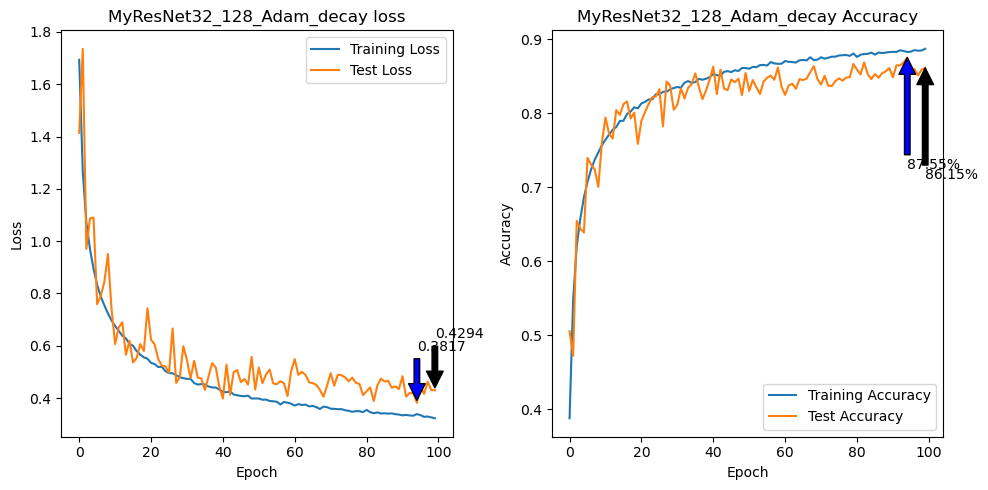

In [17]:
view = LogViewer(logs)
view.draw(save_name=file_name)

In [18]:
view.print_all()

1 epoch: train_loss=1.6936, train_acc=0.3878, test_loss=1.4143, test_acc=0.5055, lr=0.0010
2 epoch: train_loss=1.2651, train_acc=0.5486, test_loss=1.7357, test_acc=0.4721, lr=0.0010
3 epoch: train_loss=1.0715, train_acc=0.6209, test_loss=0.9703, test_acc=0.6547, lr=0.0010
4 epoch: train_loss=0.9703, train_acc=0.6576, test_loss=1.0866, test_acc=0.6441, lr=0.0010
5 epoch: train_loss=0.8939, train_acc=0.6867, test_loss=1.0898, test_acc=0.6389, lr=0.0010
6 epoch: train_loss=0.8330, train_acc=0.7075, test_loss=0.7587, test_acc=0.7399, lr=0.0010
7 epoch: train_loss=0.7885, train_acc=0.7242, test_loss=0.7902, test_acc=0.7307, lr=0.0010
8 epoch: train_loss=0.7548, train_acc=0.7374, test_loss=0.8434, test_acc=0.7243, lr=0.0010
9 epoch: train_loss=0.7237, train_acc=0.7471, test_loss=0.9506, test_acc=0.7007, lr=0.0010
10 epoch: train_loss=0.6966, train_acc=0.7569, test_loss=0.7416, test_acc=0.7605, lr=0.0010
11 epoch: train_loss=0.6757, train_acc=0.7646, test_loss=0.6064, test_acc=0.7945, lr=0.00